PBC

In [ ]:
from scipy.sparse import dia_matrix

def get_jmat_pbc(lsize, beta):
    N = lsize
    J = dia_matrix((N, N))
    mid_diag = np.floor(N/2).astype(int)
    for i in np.arange(1,mid_diag+1):
        elem = pow(i, -beta)
        J.setdiag(elem, k=i)
        J.setdiag(elem, k=-i)
    for i in np.arange(mid_diag+1, N):
        elem = pow(N-i, -beta)
        J.setdiag(elem, k=i)
        J.setdiag(elem, k=-i)
    return J.toarray()

In [84]:
N = 4
J = get_jmat_pbc(N, 0.5)
J

array([[0.        , 1.        , 0.70710678, 1.        ],
       [1.        , 0.        , 1.        , 0.70710678],
       [0.70710678, 1.        , 0.        , 1.        ],
       [1.        , 0.70710678, 1.        , 0.        ]])

## Periodic Boundary Condition

Hamiltonian,

\begin{equation}
\hat{H}(t) = \frac12\Bigg[\sum_{ij}\hat{\sigma}^x_i \hat{\sigma}^x_j + h \cos(\omega t)\sum_i \hat{\sigma}^z_i\Bigg]
\end{equation}

In [16]:
from qutip import *
from scipy import signal
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.special import jn_zeros
from itertools import combinations
from multiprocessing import Pool
from tqdm import tqdm

##-- Drive-------------------------------------------------
from scipy.sparse import dia_matrix

def get_jmat_pbc(lsize, beta):
    N = lsize
    J = dia_matrix((N, N))
    mid_diag = np.floor(N/2).astype(int)
    for i in np.arange(1,mid_diag+1):
        elem = pow(i, -beta)
        J.setdiag(elem, k=i)
        J.setdiag(elem, k=-i)
    for i in np.arange(mid_diag+1, N):
        elem = pow(N-i, -beta)
        J.setdiag(elem, k=i)
        J.setdiag(elem, k=-i)
    return J.toarray()

def drive(t, args):
    h = args['h']
    w = args['omega']
    return  h * np.cos(w * t)

def get_hamiltonian(N,beta):
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)
    H21, H22=  empt, empt
    
    
    jmat = get_jmat_pbc(N, beta)
    ##-- Hamiltonian ---------------------------------------

    comb = combinations(np.arange(N), 2)
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H21 = H21 + Qobj(tensor(id, tensor(sx, tensor(id1,tensor(sx,id2)))).full()) * jmat[i,j]
        
    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H22 = H22 + Qobj(tensor(id,tensor(sz,id1)).full()) 
    
    return 0.5*H21, 0.5*H22

##-- Dynamics
def run_dynm_corr(args):
    N=args['N']
    beta , sz_cor = args['beta'], args['sz_cor']
    H21, H22 =  get_hamiltonian(N,beta)
    
    params = args
    H = [H21,[H22,drive]]
    grket = basis(2**N,0)        
    out = mesolve(H, grket, times, [], [sz_cor], args = params)
    return out.expect

def run_dynm_corr_avg(args):
    N=args['N']
    beta , sz_cor = args['beta'], args['sz_cor']    
    H21, H22 =  get_hamiltonian(N,beta)
    
    params = args
    H = [H21,[H22,drive]]
    grket = basis(2**N,0)        
    out = mesolve(H, grket, times, [], [sz_cor], args = params)
    return np.average(out.expect)

4it [00:08,  2.04s/it]
4it [00:06,  1.70s/it]


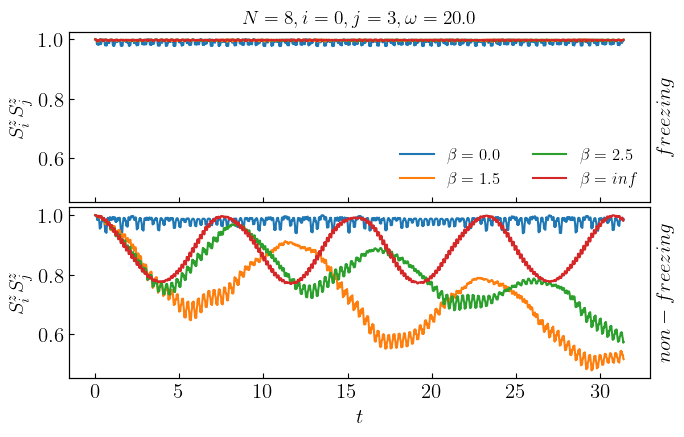

CPU times: user 15.8 s, sys: 647 ms, total: 16.4 s
Wall time: 15.7 s


In [26]:
%%time

plt.rcParams.update({"figure.figsize": (7.5,4.5),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 15,"font.sans-serif": ["Helvetica"]})
fig, axs = plt.subplots(2,1, sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.0, hspace=0.03)
freezing_pts = jn_zeros(0, 5)

N = 8
omega = 20
w = omega
T = 2 * np.pi/w
times = np.linspace(0, 100 * T, 1801, endpoint=False)

# Strong spin-coupling
#Jvalue = 1

# Weak spin-coupling
#Jvalue = 0.027/T

betas = [0.0, 1.5, 2.5, float('inf')]
pos1 = 0
pos2 = 3

sx,sy,sz = sigmax(), sigmay(), sigmaz()

opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)

frz = w/2 * jn_zeros(0,5)[2]
nfrz = w/2 * 6
hs = [frz,nfrz]


i,j = pos1, pos2
id = qeye(2**i)
dim11 = j-i-1
id1 = qeye(2**dim11)
dim12 = N-1-j
id2 = qeye(2**dim12)
sz_cor = Qobj(tensor(id, tensor(sz, tensor(id1, tensor(sz,id2)))).full()) 

for hh, h in enumerate(hs):
    for b, beta in tqdm(enumerate(betas)):
        sz_o = qzero(2**N) + 1j * qzero(2**N)

        param = {'h0':0, 'h':h, 'omega':omega, 'N':N,\
                   'opts':opts, 'sz_cor':sz_cor,'beta':beta,'times':times}
        data = run_dynm_corr(param)

        axs[hh].plot(times, data[0], label=fr'$\beta={beta}$')        
        axs[hh].set_ylabel(r"$ S^z_i S^z_j$")
        
        axs[hh].tick_params(which='both', axis="x", direction="in")
        axs[hh].tick_params(which='both', axis="y", direction="in")
        #axs[hh].set_ylim(-1.1,1.1)

#plt.xlim(4,10)
#plt.ylim(.9999,1)
axs[1].set_ylabel(r"$ S^z_i S^z_j$")
axs[1].set_xlabel(r"$t$")
axs[0].legend(frameon =False, fontsize =12, ncol=2, loc=4)
axs[0].set_title(fr"$N={N}, i={i}, j={j}, \omega={w:3.1f}$", fontsize= 14)


ax2 = axs[0].twinx()
ax2.set_ylabel(r'$freezing$')
ax2.set_yticks([])

ax3 = axs[1].twinx()
ax3.set_ylabel(r'$non-freezing$')
ax3.set_yticks([])
#plt.savefig('corrN8sy0sy3_tfim.svg', bbox_inches='tight', pad_inches=0.0, dpi = 300)
plt.savefig('corrN8sz0sz3_tfim3.jpeg', bbox_inches='tight', pad_inches=0.0, dpi = 300)
plt.show()

beta= 0.5
beta= 1.5
beta= 2.5
beta= inf


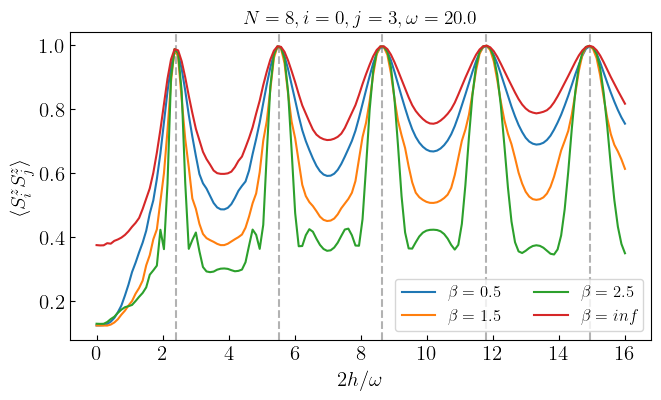

CPU times: user 928 ms, sys: 341 ms, total: 1.27 s
Wall time: 10min 12s


In [2]:
%%time

freezing_pts = jn_zeros(0, 5)
plt.rcParams.update({"figure.figsize": (7.5,4),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 15,"font.sans-serif": ["Helvetica"]})

N = 8
omega = 20
w = omega
T = 2 * np.pi/w
times = np.linspace(0, 300 * T, 1500, endpoint=False)

# Strong spin-coupling
#Jvalue = 1

# Weak spin-coupling
#Jvalue = 0.027/T

betas = [0.5, 1.5, 2.5, float('inf')]
pos1 = 0
pos2 = 3

sx,sy,sz = sigmax(), sigmay(), sigmaz()
nprocs = 8
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)

hs = w/2 * np.linspace(0,16, 150)
for i,xx in enumerate(jn_zeros(0,5)):
    plt.axvline(x=xx, alpha=0.3, color = 'black', linestyle = '--')

i,j = pos1, pos2
id = qeye(2**i)
dim11 = j-i-1
id1 = qeye(2**dim11)
dim12 = N-1-j
id2 = qeye(2**dim12)
sz_cor = Qobj(tensor(id, tensor(sz, tensor(id1, tensor(sz,id2)))).full()) 

for b, beta in enumerate(betas):
    sz_o = qzero(2**N) + 1j * qzero(2**N)
    print('beta=',beta)

    param = [{'h0':0, 'h':h, 'omega':omega, 'N':N,\
               'opts':opts, 'sz_cor':sz_cor,\
               'beta':beta,\
               'times':times} for h in hs]

    data = p.map(run_dynm_corr_avg,param)

    plt.plot(2*hs/w, data, label=fr'$\beta={beta}$')
    plt.legend(frameon =True, fontsize =12)
    plt.ylabel(r"$\langle S^z_i S^z_j \rangle$")
    plt.tick_params(which='both', axis="x", direction="in")
    plt.tick_params(which='both', axis="y", direction="in")
    

plt.xlabel(r"$2h/\omega$")
plt.legend(frameon =True, fontsize =12, ncol=2, loc=4)
plt.title(fr"$N={N}, i={i}, j={j}, \omega={w:3.1f}$", fontsize= 14)

plt.savefig('corrN8sz0sz3avg_tfim.svg', dpi=300,bbox_inches='tight', pad_inches=0.0)
plt.savefig('corrN8sz0sz3avg_tfim.pdf', bbox_inches='tight', pad_inches=0.0)
plt.show()

Hamiltonian,

\begin{equation}
\hat{H}(t) = \frac12\Bigg[\sum_{ij}\hat{\sigma}^x_i \hat{\sigma}^x_j + h \cos(\omega t)\sum_i \hat{\sigma}^z_i + \sum_i  \hat{\sigma}^x_i\Bigg]
\end{equation}

In [1]:
from qutip import *
from scipy import signal
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.special import jn_zeros
from itertools import combinations
from multiprocessing import Pool
from tqdm import tqdm


##-- Drive-------------------------------------------------
from scipy.sparse import dia_matrix

def get_jmat_pbc(lsize, beta):
    N = lsize
    J = dia_matrix((N, N))
    mid_diag = np.floor(N/2).astype(int)
    for i in np.arange(1,mid_diag+1):
        elem = pow(i, -beta)
        J.setdiag(elem, k=i)
        J.setdiag(elem, k=-i)
    for i in np.arange(mid_diag+1, N):
        elem = pow(N-i, -beta)
        J.setdiag(elem, k=i)
        J.setdiag(elem, k=-i)
    return J.toarray()

def drive(t, args):
    h = args['h']
    w = args['omega']
    return  h * np.cos(w * t)

def get_hamiltonian(N,beta):
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)
    H21, H22, H23=  empt, empt, empt
    
    
    jmat = get_jmat_pbc(N, beta)
    ##-- Hamiltonian ---------------------------------------

    comb = combinations(np.arange(N), 2)
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H21 = H21 + Qobj(tensor(id, tensor(sx, tensor(id1,tensor(sx,id2)))).full()) * jmat[i,j]
        
    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H22 = H22 + Qobj(tensor(id,tensor(sz,id1)).full()) 
        
    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H23 = H23 + Qobj(tensor(id,tensor(sx,id1)).full()) 
    
    return 0.5*H21, 0.5*H22, 0.5*H23

##-- Dynamics
def run_dynm_corr(args):
    N=args['N']
    beta , sz_cor = args['beta'], args['sz_cor']
    H21, H22, H23 =  get_hamiltonian(N,beta)
    
    params = args
    H = [H21,[H22,drive], H23]
    grket = basis(2**N,0)        
    out = mesolve(H, grket, times, [], [sz_cor], args = params)
    return out.expect

def run_dynm_corr_avg(args):
    N=args['N']
    beta , sz_cor = args['beta'], args['sz_cor']    
    H21, H22, H23 =  get_hamiltonian(N,beta)
    
    params = args
    H = [H21,[H22,drive], H23]
    grket = basis(2**N,0)        
    out = mesolve(H, grket, times, [], [sz_cor], args = params)
    return np.average(out.expect)

1it [00:06,  6.03s/it]
1it [00:03,  3.25s/it]


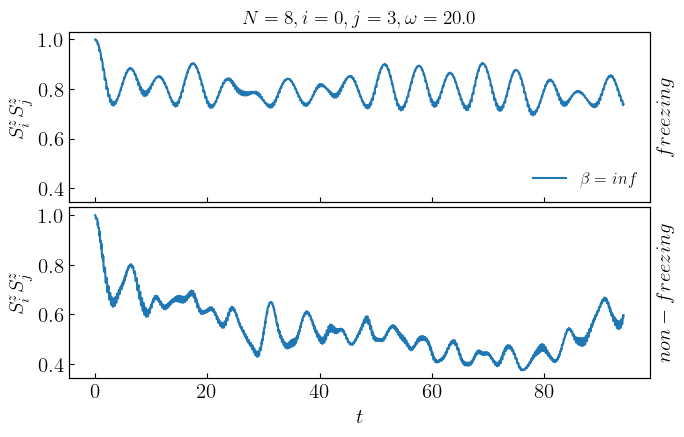

CPU times: user 9.9 s, sys: 188 ms, total: 10.1 s
Wall time: 9.84 s


In [8]:
%%time

plt.rcParams.update({"figure.figsize": (7.5,4.5),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 15,"font.sans-serif": ["Helvetica"]})
fig, axs = plt.subplots(2,1, sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.0, hspace=0.03)
freezing_pts = jn_zeros(0, 5)

N = 8
omega = 20
w = omega
T = 2 * np.pi/w
times = np.linspace(0, 300 * T, 1500, endpoint=False)

# Strong spin-coupling
#Jvalue = 1

# Weak spin-coupling
#Jvalue = 0.027/T

#betas = [0.5, 1.5, 2.5, float('inf')]
betas = [float('inf')]
pos1 = 0
pos2 = 3

sx,sy,sz = sigmax(), sigmay(), sigmaz()

opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)

frz = w/2 * jn_zeros(0,5)[4]
nfrz = w/2 * 6
hs = [frz,nfrz]


i,j = pos1, pos2
id = qeye(2**i)
dim11 = j-i-1
id1 = qeye(2**dim11)
dim12 = N-1-j
id2 = qeye(2**dim12)
sz_cor = Qobj(tensor(id, tensor(sz, tensor(id1, tensor(sz,id2)))).full()) 

for hh, h in enumerate(hs):
    for b, beta in tqdm(enumerate(betas)):
        sz_o = qzero(2**N) + 1j * qzero(2**N)

        param = {'h0':0, 'h':h, 'omega':omega, 'N':N,\
                   'opts':opts, 'sz_cor':sz_cor,'beta':beta,'times':times}
        data = run_dynm_corr(param)

        axs[hh].plot(times, data[0], label=fr'$\beta={beta}$')        
        axs[hh].set_ylabel(r"$ S^z_i S^z_j$")
        
        axs[hh].tick_params(which='both', axis="x", direction="in")
        axs[hh].tick_params(which='both', axis="y", direction="in")

#plt.xlim(4,10)
#plt.ylim(.9999,1)
axs[1].set_ylabel(r"$ S^z_i S^z_j$")
axs[1].set_xlabel(r"$t$")
axs[0].legend(frameon =False, fontsize =12, ncol=2, loc=4)
axs[0].set_title(fr"$N={N}, i={i}, j={j}, \omega={w:3.1f}$", fontsize= 14)

ax2 = axs[0].twinx()
ax2.set_ylabel(r'$freezing$')
ax2.set_yticks([])

ax3 = axs[1].twinx()
ax3.set_ylabel(r'$non-freezing$')
ax3.set_yticks([])
plt.savefig('corrN8sz0sz3_tfim_sx.svg', bbox_inches='tight', pad_inches=0.0, dpi = 300)
plt.show()

beta= 0.5


Process ForkPoolWorker-158:
Process ForkPoolWorker-159:
Process ForkPoolWorker-155:
Process ForkPoolWorker-157:
Process ForkPoolWorker-156:
Process ForkPoolWorker-153:
Process ForkPoolWorker-160:
Process ForkPoolWorker-154:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mahi/anaconda3/envs/work3p8/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/mahi/anaconda3/envs/work3p8/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/mahi/anaconda3/envs/work3p8/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/mahi/anaconda3/envs/work3p8/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()


KeyboardInterrupt: 

  File "/home/mahi/anaconda3/envs/work3p8/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mahi/anaconda3/envs/work3p8/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/mahi/anaconda3/envs/work3p8/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mahi/anaconda3/envs/work3p8/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mahi/anaconda3/envs/work3p8/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/mahi/anaconda3/envs/work3p8/lib/python3.8/multiprocessing/queues.py", line 356, in get
    res = self._reader.recv_bytes()
  File "/home/mahi/anaconda3/envs/work3p8/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mahi/anaconda3/envs/work3p8/lib/python3.8/m

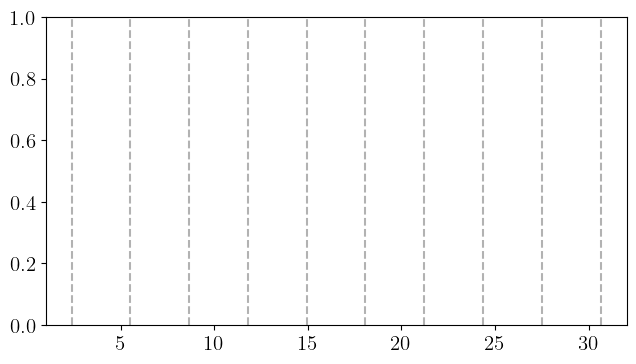

Process ForkPoolWorker-172:
Process ForkPoolWorker-170:
Process ForkPoolWorker-174:
Process ForkPoolWorker-169:
Process ForkPoolWorker-163:
Process ForkPoolWorker-168:
Traceback (most recent call last):
Process ForkPoolWorker-176:
Process ForkPoolWorker-171:
Process ForkPoolWorker-173:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-164:
Traceback (most recent call last):
Process ForkPoolWorker-165:
Process ForkPoolWorker-167:
Process ForkPoolWorker-166:
Traceback (most recent call last):
Process ForkPoolWorker-175:
Traceback (most recent call last):
Process ForkPoolWorker-161:
Process ForkPoolWorker-162:
  File "/home/mahi/anaconda3/envs/work3p8/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/mahi/anaconda3/envs/work3p8/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/mahi/anaconda3/envs/work3p8/lib/python3.8/mul

In [22]:
%%time

freezing_pts = jn_zeros(0, 5)
plt.rcParams.update({"figure.figsize": (7.5,4),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 15,"font.sans-serif": ["Helvetica"]})

N = 8
omega = 90
w = omega
T = 2 * np.pi/w
times = np.linspace(0, 100 * T, 500, endpoint=False)

# Strong spin-coupling
#Jvalue = 1

# Weak spin-coupling
#Jvalue = 0.027/T

betas = [0.5, 1.5, 2.5, float('inf')]
pos1 = 0
pos2 = 3

sx,sy,sz = sigmax(), sigmay(), sigmaz()
nprocs = 8
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)

hs = w/2 * np.linspace(0,32, 150)
for i,xx in enumerate(jn_zeros(0,10)):
    plt.axvline(x=xx, alpha=0.3, color = 'black', linestyle = '--')

i,j = pos1, pos2
id = qeye(2**i)
dim11 = j-i-1
id1 = qeye(2**dim11)
dim12 = N-1-j
id2 = qeye(2**dim12)
sz_cor = Qobj(tensor(id, tensor(sz, tensor(id1, tensor(sz,id2)))).full()) 

for b, beta in enumerate(betas):
    sz_o = qzero(2**N) + 1j * qzero(2**N)
    print('beta=',beta)

    param = [{'h0':0, 'h':h, 'omega':omega, 'N':N,\
               'opts':opts, 'sz_cor':sz_cor,\
               'beta':beta,\
               'times':times} for h in hs]

    data = p.map(run_dynm_corr_avg,param)

    plt.plot(2*hs/w, data, label=fr'$\beta={beta}$')
    plt.legend(frameon =True, fontsize =12)
    plt.ylabel(r"$\langle S^z_i S^z_j \rangle$")
    plt.tick_params(which='both', axis="x", direction="in")
    plt.tick_params(which='both', axis="y", direction="in")
    

plt.xlabel(r"$2h/\omega$")
plt.legend(frameon =True, fontsize =12, ncol=2, loc=4)
plt.title(fr"$N={N}, i={i}, j={j}", fontsize= 14)
plt.savefig('corrN8sz0sz3avg_tfim_sx.svg', dpi=300,bbox_inches='tight', pad_inches=0.0)
plt.savefig('corrN8sz0sz3avg_tfim_sx.pdf', bbox_inches='tight', pad_inches=0.0)
plt.show()

### only $\beta = \infty$, i.e. nearest neighbour

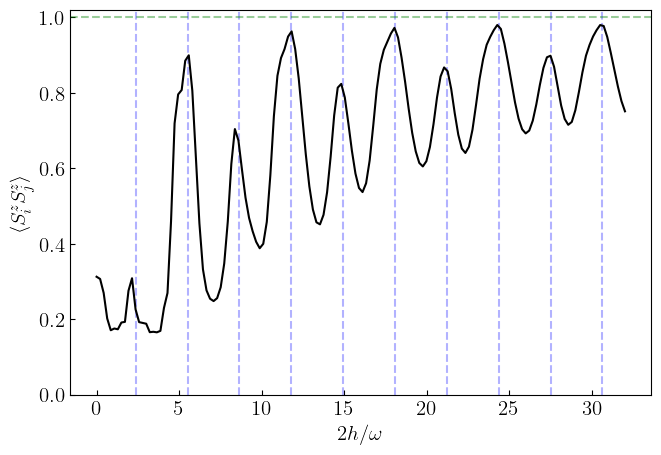

CPU times: user 526 ms, sys: 333 ms, total: 859 ms
Wall time: 1min 24s


In [3]:
%%time

freezing_pts = jn_zeros(0, 5)
plt.rcParams.update({"figure.figsize": (7.5,5),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 15,"font.sans-serif": ["Helvetica"]})

N = 8
omega = 20
w = omega
T = 2 * np.pi/w
times = np.linspace(0, 100 * T, 500, endpoint=False)

# Strong spin-coupling
#Jvalue = 1

# Weak spin-coupling
#Jvalue = 0.027/T

pos1 = 0
pos2 = 3

sx,sy,sz = sigmax(), sigmay(), sigmaz()
nprocs = 8
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)

hs = w/2 * np.linspace(0,32, 150)
for i,xx in enumerate(jn_zeros(0,10)):
    plt.axvline(x=xx, alpha=0.3, color = 'blue', linestyle = '--')

i,j = pos1, pos2
id = qeye(2**i)
dim11 = j-i-1
id1 = qeye(2**dim11)
dim12 = N-1-j
id2 = qeye(2**dim12)
sz_cor = Qobj(tensor(id, tensor(sz, tensor(id1, tensor(sz,id2)))).full()) 

beta = float('inf')
sz_o = qzero(2**N) + 1j * qzero(2**N)

param = [{'h0':0, 'h':h, 'omega':omega, 'N':N,\
           'opts':opts, 'sz_cor':sz_cor,\
           'beta':beta,\
           'times':times} for h in hs]

data = p.map(run_dynm_corr_avg,param)

plt.plot(2*hs/w, data, color='black')
plt.yticks([0.0,0.2,0.4,0.6,0.8,1.0])
plt.ylabel(r"$\langle S^z_i S^z_j \rangle$")
plt.tick_params(which='both', axis="x", direction="in")
plt.tick_params(which='both', axis="y", direction="in")
plt.axhline(y=1.0, color='green', alpha=0.4, linestyle='--')
    
plt.xlabel(r"$2h/\omega$")
#plt.title(fr"$N={N}, i={i}, j={j}, \omega={w:3.1f}$", fontsize= 14)
plt.savefig('corrN8sz0sz3avg_onlynn_tfim_sx.svg', dpi=300,bbox_inches='tight', pad_inches=0.0)
plt.savefig('corrN8sz0sz3avg_onlynn_tfim_sx.jpeg', dpi=300,bbox_inches='tight', pad_inches=0.0)
#plt.savefig('corrN8sz0sz3avg_onlynn_tfim_sx.pdf', bbox_inches='tight', pad_inches=0.0)
plt.show()

# XXZ model

Hamiltonian,

\begin{equation}
\hat{H}(t) = \frac12\Bigg[J\sum_{ij} (\hat{\sigma}^x_i \hat{\sigma}^x_j +\hat{\sigma}^y_i \hat{\sigma}^y_j)+ \Delta\hat{\sigma}^z_i \hat{\sigma}^z_j+ h \cos(\omega t)\sum_i \hat{\sigma}^z_i\Bigg]
\end{equation}

In [7]:
from qutip import *
from scipy import signal
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.special import jn_zeros
from itertools import combinations
from multiprocessing import Pool
from tqdm import tqdm

##--- Energy per spin for interaction range order---------
def j_ij(Jvalue, i,j, beta):
    return Jvalue/(np.abs(i-j))**beta

##-- Drive-------------------------------------------------
from scipy.sparse import dia_matrix

def get_jmat_pbc(lsize, beta):
    N = lsize
    J = dia_matrix((N, N))
    mid_diag = np.floor(N/2).astype(int)
    for i in np.arange(1,mid_diag+1):
        elem = pow(i, -beta)
        J.setdiag(elem, k=i)
        J.setdiag(elem, k=-i)
    for i in np.arange(mid_diag+1, N):
        elem = pow(N-i, -beta)
        J.setdiag(elem, k=i)
        J.setdiag(elem, k=-i)
    return J.toarray()

def drive(t, args):
    h = args['h']
    w = args['omega']
    return h * np.cos(w * t)

def get_hamiltonian(N, beta, del_an):
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)
    H11, H12, H13, H21 =  empt, empt, empt, empt
    
    
    jmat = get_jmat_pbc(N, beta)
    ##-- Hamiltonian ---------------------------------------

    comb = combinations(np.arange(N), 2)
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H11 = H11 + Qobj(tensor(id, tensor(sx, tensor(id1,tensor(sx,id2)))).full()) * jmat[i,j]
        
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H12 = H12 + Qobj(tensor(id, tensor(sy, tensor(id1,tensor(sy,id2)))).full()) * jmat[i,j]
        
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H13 = H13 + Qobj(tensor(id, tensor(sz, tensor(id1,tensor(sz,id2)))).full()) * jmat[i,j] * del_an
        
    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H21 = H21 + Qobj(tensor(id,tensor(sz,id1)).full()) 
    
    return 0.5*H11, 0.5*H12, 0.5*H13, 0.5*H21

##-- Dynamics
def run_dynm_corr(args):
    N=args['N']
    beta , sz_cor, del_an = args['beta'], args['sz_cor'], args['del_an']
    H11, H12, H13, H21 =  get_hamiltonian(N, beta, del_an)
    
    params = args
    #H = [H21,[H22,drive]]
    H = [H11,H12,H13,[H21,drive]]
    grket = basis(2**N,0)        
    out = mesolve(H, grket, times, [], [sz_cor], args = params)
    return out.expect

def run_dynm_corr_avg(args):
    N=args['N']
    beta , sz_cor, del_an = args['beta'], args['sz_cor'], args['del_an']    
    H11, H12, H13, H21 =  get_hamiltonian(N, beta, del_an)
    
    params = args
    H = [H11,H12,H13,[H21,drive]]
    grket = basis(2**N,0)        
    out = mesolve(H, grket, times, [], [sz_cor], args = params)
    return np.average(out.expect)

print('Function defined ..')

Function defined ..


### $\Delta = 0.5$

1it [00:00,  1.12it/s]
1it [00:01,  1.18s/it]


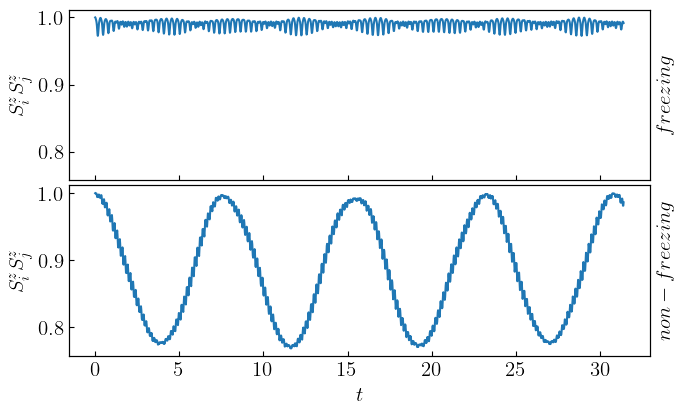

CPU times: user 2.59 s, sys: 131 ms, total: 2.72 s
Wall time: 2.91 s


In [19]:
%%time

plt.rcParams.update({"figure.figsize": (7.5,4.5),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 15,"font.sans-serif": ["Helvetica"]})
fig, axs = plt.subplots(2,1, sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.0, hspace=0.03)
freezing_pts = jn_zeros(0, 5)

N = 8
omega = 20
w = omega
T = 2 * np.pi/w
times = np.linspace(0, 100 * T, 1801, endpoint=False)
del_an = 0.5
# Strong spin-coupling
#Jvalue = 1

# Weak spin-coupling
#Jvalue = 0.027/T

#betas = [0.5, 1.5, 2.5, float('inf')]
betas = [float('inf')]
pos1 = 0
pos2 = 3

sx,sy,sz = sigmax(), sigmay(), sigmaz()
nprocs = 8
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)

frz = w/2 * jn_zeros(0,5)[0]
nfrz = w/2 * 6
hs = [frz,nfrz]


i,j = pos1, pos2
id = qeye(2**i)
dim11 = j-i-1
id1 = qeye(2**dim11)
dim12 = N-1-j
id2 = qeye(2**dim12)
sz_cor = Qobj(tensor(id, tensor(sz, tensor(id1, tensor(sz,id2)))).full()) 

for hh, h in enumerate(hs):
    for b, beta in tqdm(enumerate(betas)):
        sz_o = qzero(2**N) + 1j * qzero(2**N)

        param = {'h0':0, 'h':h, 'omega':omega, 'N':N,\
                   'opts':opts, 'sz_cor':sz_cor,'beta':beta,'times':times, 'del_an':del_an}
        data = run_dynm_corr(param)

        #axs[hh].plot(times, data[0], label=fr'$\beta={beta}$')     
        axs[hh].plot(times, data[0])     
        axs[hh].set_ylabel(r"$ S^z_i S^z_j$")
        
        axs[hh].tick_params(which='both', axis="x", direction="in")
        axs[hh].tick_params(which='both', axis="y", direction="in")

axs[1].set_ylabel(r"$ S^z_i S^z_j$")
axs[1].set_xlabel(r"$t$")

#axs[0].legend(frameon =False, fontsize =12, ncol=2, loc=4)
#axs[0].set_title(fr"$N={N}, i={i}, j={j}, \omega={w:3.1f}$", fontsize= 14)

ax2 = axs[0].twinx()
ax2.set_ylabel(r'$freezing$')
ax2.set_yticks([])

ax3 = axs[1].twinx()
ax3.set_ylabel(r'$non-freezing$')
ax3.set_yticks([])
plt.savefig('corrN8sz0sz3_xxz_onlynn_an0p5.svg', bbox_inches='tight', pad_inches=0.0, dpi = 300)
#plt.savefig('corrN8sz0sz3_xxz_onlynn_an0p5.pdf', bbox_inches='tight', pad_inches=0.0)
plt.show()

beta= inf


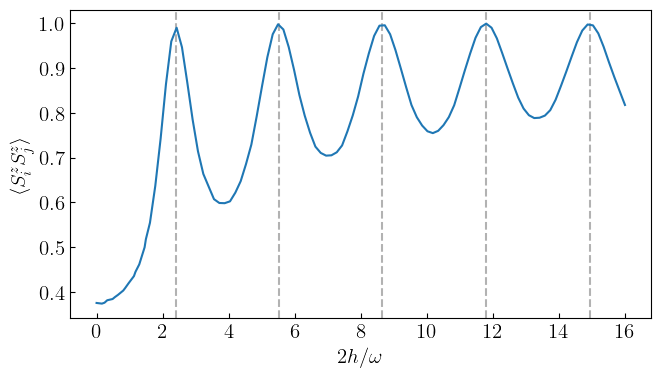

CPU times: user 273 ms, sys: 130 ms, total: 404 ms
Wall time: 1min 2s


In [7]:
%%time

freezing_pts = jn_zeros(0, 5)
plt.rcParams.update({"figure.figsize": (7.5,4),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 15,"font.sans-serif": ["Helvetica"]})

N = 8
omega = 20
w = omega
T = 2 * np.pi/w
times = np.linspace(0, 300 * T, 1500, endpoint=False)
del_an = 0.5
# Strong spin-coupling
#Jvalue = 1

# Weak spin-coupling
#Jvalue = 0.027/T

betas = [0.5, 1.5, 2.5, float('inf')]
#betas = [float('inf')]
pos1 = 0
pos2 = 3

sx,sy,sz = sigmax(), sigmay(), sigmaz()
nprocs = 8
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)

hss = w/2 * np.linspace(0,16, 100)
hs = np.sort(np.append(hss, jn_zeros(0,5)))
for i,xx in enumerate(jn_zeros(0,5)):
    plt.axvline(x=xx, alpha=0.3, color = 'black', linestyle = '--')

i,j = pos1, pos2
id = qeye(2**i)
dim11 = j-i-1
id1 = qeye(2**dim11)
dim12 = N-1-j
id2 = qeye(2**dim12)
sz_cor = Qobj(tensor(id, tensor(sz, tensor(id1, tensor(sz,id2)))).full()) 

for b, beta in enumerate(betas):
    sz_o = qzero(2**N) + 1j * qzero(2**N)
    print('beta=',beta)

    param = [{'h0':0, 'h':h, 'omega':omega, 'N':N,\
               'opts':opts, 'sz_cor':sz_cor,\
               'beta':beta,'del_an':del_an,\
               'times':times} for h in hs]

    data = p.map(run_dynm_corr_avg,param)

    #plt.plot(2*hs/w, data, label=fr'$\beta={beta}$')
    plt.plot(2*hs/w, data)
    #plt.legend(frameon =True, fontsize =12)
    plt.ylabel(r"$\langle S^z_i S^z_j \rangle$")
    plt.tick_params(which='both', axis="x", direction="in")
    plt.tick_params(which='both', axis="y", direction="in")
    

plt.xlabel(r"$2h/\omega$")
plt.legend(frameon =True, fontsize =12, ncol=2, loc=4)
plt.title(fr"$N={N}, i={i}, j={j}, \omega={w:3.1f}$", fontsize= 14)
plt.savefig('corrN8sz0sz3avg_xxz_an0p5.svg', dpi=300,bbox_inches='tight', pad_inches=0.0)
plt.show()

### only $\beta = \infty$ i.e. nearest neighbour

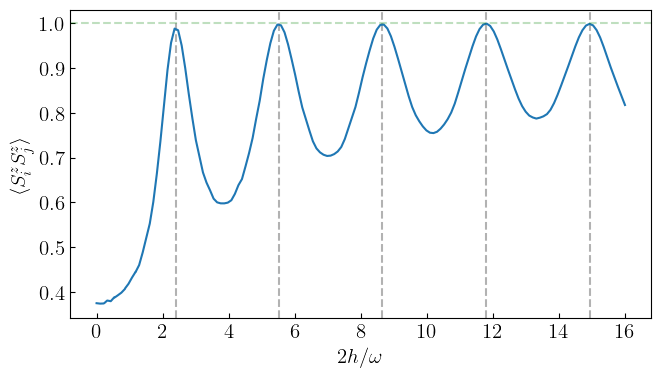

CPU times: user 413 ms, sys: 148 ms, total: 561 ms
Wall time: 1min 34s


In [9]:
%%time

freezing_pts = jn_zeros(0, 5)
plt.rcParams.update({"figure.figsize": (7.5,4),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 15,"font.sans-serif": ["Helvetica"]})

N = 8
omega = 20
w = omega
T = 2 * np.pi/w
times = np.linspace(0, 300 * T, 1500, endpoint=False)
del_an = 0.5
beta = float('inf')
pos1 = 0
pos2 = 3

sx,sy,sz = sigmax(), sigmay(), sigmaz()
nprocs = 8
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)

hss = w/2 * np.linspace(0,16, 150)
hs = np.sort(np.append(hss, jn_zeros(0,5)))

fig, ax1 = plt.subplots(1,1)
#left, bottom, width, height = [0.55, 0.25, 0.3, 0.31]
#ax2 = fig.add_axes([left, bottom, width, height])


for i,xx in enumerate(jn_zeros(0,5)):
    ax1.axvline(x=xx, alpha=0.3, color = 'black', linestyle = '--')
    #ax2.axvline(x=xx, alpha=0.3, color = 'black', linestyle = '--')

i,j = pos1, pos2
id = qeye(2**i)
dim11 = j-i-1
id1 = qeye(2**dim11)
dim12 = N-1-j
id2 = qeye(2**dim12)
sz_cor = Qobj(tensor(id, tensor(sz, tensor(id1, tensor(sz,id2)))).full()) 

sz_o = qzero(2**N) + 1j * qzero(2**N)

param = [{'h0':0, 'h':h, 'omega':omega, 'N':N,\
           'opts':opts, 'sz_cor':sz_cor,\
           'beta':beta,'del_an':del_an,\
           'times':times} for h in hs]

data = p.map(run_dynm_corr_avg,param)

ax1.plot(2*hs/w, data)
ax1.set_ylabel(r"$\langle S^z_i S^z_j \rangle$")
ax1.tick_params(which='both', axis="x", direction="in")
ax1.tick_params(which='both', axis="y", direction="in")    
ax1.set_xlabel(r"$2h/\omega$")
ax1.axhline(y=1.0, color='green', alpha=0.25, linestyle='--')

'''
ax2.plot(2*hs/w, data)
ax2.set_ylabel(r"$\langle S^z_i S^z_j \rangle$", fontsize =10)
ax2.set_xlabel(r"$2h/\omega$", fontsize = 10, labelpad=0.0)
ax2.tick_params(which='both', axis="x", direction="in")
ax2.tick_params(which='both', axis="y", direction="in")
ax2.set_ylim(0.98,1.01)
ax2.axhline(y=1.0, color='green', alpha=0.25, linestyle='--')
'''

plt.savefig('corrN8sz0sz3avg_xxz_onlynn_an0p5.svg', dpi=300,bbox_inches='tight', pad_inches=0.0)
plt.savefig('corrN8sz0sz3avg_xxz_onlynn_an0p5.jpeg', dpi=300,bbox_inches='tight', pad_inches=0.0)


plt.show()

#### $\beta= 0$

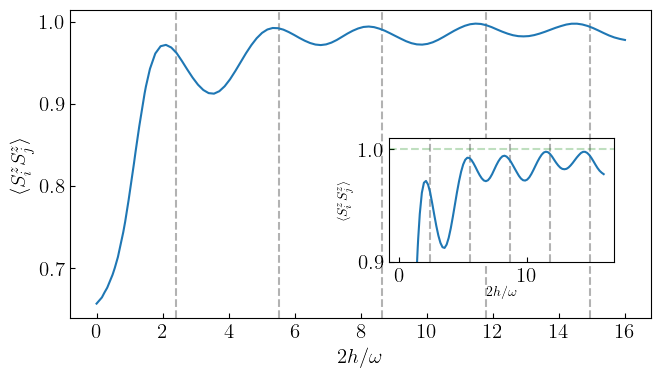

CPU times: user 328 ms, sys: 123 ms, total: 450 ms
Wall time: 1min 39s


In [23]:
%%time

freezing_pts = jn_zeros(0, 5)
plt.rcParams.update({"figure.figsize": (7.5,4),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 15,"font.sans-serif": ["Helvetica"]})

N = 8
omega = 20
w = omega
T = 2 * np.pi/w
times = np.linspace(0, 300 * T, 1500, endpoint=False)
del_an = 1.5
beta = 0.0
pos1 = 0
pos2 = 3

sx,sy,sz = sigmax(), sigmay(), sigmaz()
nprocs = 8
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)

hss = w/2 * np.linspace(0,16, 100)
hs = np.sort(np.append(hss, jn_zeros(0,5)))

fig, ax1 = plt.subplots(1,1)
left, bottom, width, height = [0.55, 0.25, 0.3, 0.31]
ax2 = fig.add_axes([left, bottom, width, height])


for i,xx in enumerate(jn_zeros(0,5)):
    ax1.axvline(x=xx, alpha=0.3, color = 'black', linestyle = '--')
    ax2.axvline(x=xx, alpha=0.3, color = 'black', linestyle = '--')

i,j = pos1, pos2
id = qeye(2**i)
dim11 = j-i-1
id1 = qeye(2**dim11)
dim12 = N-1-j
id2 = qeye(2**dim12)
sz_cor = Qobj(tensor(id, tensor(sz, tensor(id1, tensor(sz,id2)))).full()) 

sz_o = qzero(2**N) + 1j * qzero(2**N)

param = [{'h0':0, 'h':h, 'omega':omega, 'N':N,\
           'opts':opts, 'sz_cor':sz_cor,\
           'beta':beta,'del_an':del_an,\
           'times':times} for h in hs]

data = p.map(run_dynm_corr_avg,param)

ax1.plot(2*hs/w, data)
ax1.set_ylabel(r"$\langle S^z_i S^z_j \rangle$")
ax1.tick_params(which='both', axis="x", direction="in")
ax1.tick_params(which='both', axis="y", direction="in")    
ax1.set_xlabel(r"$2h/\omega$")

ax2.plot(2*hs/w, data)
ax2.set_ylabel(r"$\langle S^z_i S^z_j \rangle$", fontsize =10)
ax2.set_xlabel(r"$2h/\omega$", fontsize = 10, labelpad=0.0)
ax2.tick_params(which='both', axis="x", direction="in")
ax2.tick_params(which='both', axis="y", direction="in")
ax2.set_ylim(0.9,1.01)
ax2.axhline(y=1.0, color='green', alpha=0.25, linestyle='--')

plt.savefig('corrN8sz0sz3avg_xxz_a2a_an0p5.svg', dpi=300,bbox_inches='tight', pad_inches=0.0)

plt.show()

### $\Delta = 1.5$

4it [00:05,  1.29s/it]
4it [00:06,  1.72s/it]


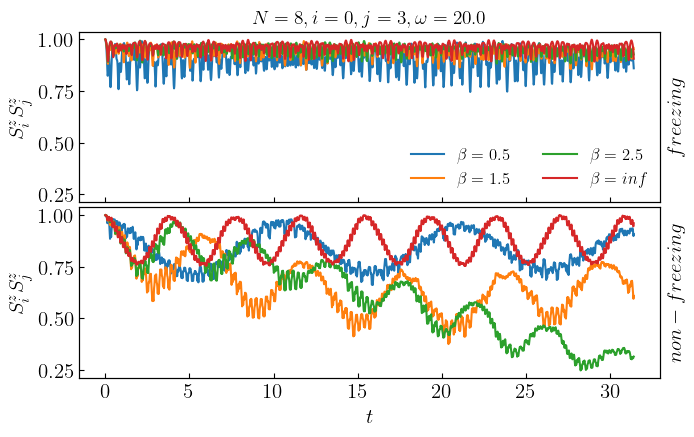

CPU times: user 12.9 s, sys: 421 ms, total: 13.3 s
Wall time: 12.9 s


In [16]:
%%time

plt.rcParams.update({"figure.figsize": (7.5,4.5),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 15,"font.sans-serif": ["Helvetica"]})
fig, axs = plt.subplots(2,1, sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.0, hspace=0.03)
freezing_pts = jn_zeros(0, 5)

N = 8
omega = 20
w = omega
T = 2 * np.pi/w
times = np.linspace(0, 100 * T, 1801, endpoint=False)
del_an = 1.5
# Strong spin-coupling
#Jvalue = 1

# Weak spin-coupling
#Jvalue = 0.027/T

betas = [0.5, 1.5, 2.5, float('inf')]
pos1 = 0
pos2 = 3

sx,sy,sz = sigmax(), sigmay(), sigmaz()
nprocs = 8
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)

frz = w/4 * jn_zeros(0,5)[0]
nfrz = w/4 * 6
hs = [frz,nfrz]


i,j = pos1, pos2
id = qeye(2**i)
dim11 = j-i-1
id1 = qeye(2**dim11)
dim12 = N-1-j
id2 = qeye(2**dim12)
sz_cor = Qobj(tensor(id, tensor(sz, tensor(id1, tensor(sz,id2)))).full()) 

for hh, h in enumerate(hs):
    for b, beta in tqdm(enumerate(betas)):
        sz_o = qzero(2**N) + 1j * qzero(2**N)

        param = {'h0':0, 'h':h, 'omega':omega, 'N':N,\
                   'opts':opts, 'sz_cor':sz_cor,'beta':beta,'times':times, 'del_an':del_an}
        data = run_dynm_corr(param)

        #axs[hh].plot(times, data[0], label=fr'$\beta={beta}$') 
        axs[hh].plot(times, data[0]) 
        axs[hh].set_ylabel(r"$ S^z_i S^z_j$")
        
        axs[hh].tick_params(which='both', axis="x", direction="in")
        axs[hh].tick_params(which='both', axis="y", direction="in")

#plt.xlim(4,10)
#plt.ylim(.9999,1)
axs[1].set_ylabel(r"$ S^z_i S^z_j$")
axs[1].set_xlabel(r"$t$")
#axs[0].legend(frameon =False, fontsize =12, ncol=2, loc=4)
#axs[0].set_title(fr"$N={N}, i={i}, j={j}, \omega={w:3.1f}$", fontsize= 14)

ax2 = axs[0].twinx()
ax2.set_ylabel(r'$freezing$')
ax2.set_yticks([])

ax3 = axs[1].twinx()
ax3.set_ylabel(r'$non-freezing$')
ax3.set_yticks([])
plt.savefig('corrN8sz0sz3_xxz_an1p5.svg', bbox_inches='tight', pad_inches=0.0, dpi = 300)
plt.show()

beta= 0.5
beta= 1.5
beta= 2.5
beta= inf


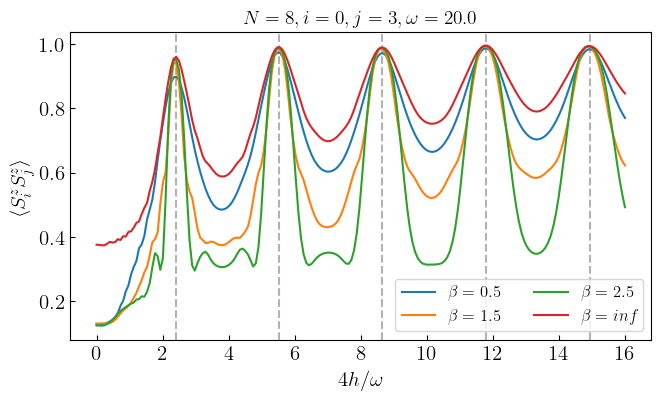

CPU times: user 581 ms, sys: 181 ms, total: 763 ms
Wall time: 4min 21s


In [17]:
%%time

freezing_pts = jn_zeros(0, 5)
plt.rcParams.update({"figure.figsize": (7.5,4),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 15,"font.sans-serif": ["Helvetica"]})

N = 8
omega = 20
w = omega
T = 2 * np.pi/w
times = np.linspace(0, 100 * T, 500, endpoint=False)
del_an = 1.5
# Strong spin-coupling
#Jvalue = 1

# Weak spin-coupling
#Jvalue = 0.027/T

betas = [0.5, 1.5, 2.5, float('inf')]
pos1 = 0
pos2 = 3

sx,sy,sz = sigmax(), sigmay(), sigmaz()
nprocs = 8
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)

hs = w/4 * np.linspace(0,16, 200)
for i,xx in enumerate(jn_zeros(0,5)):
    plt.axvline(x=xx, alpha=0.3, color = 'black', linestyle = '--')

i,j = pos1, pos2
id = qeye(2**i)
dim11 = j-i-1
id1 = qeye(2**dim11)
dim12 = N-1-j
id2 = qeye(2**dim12)
sz_cor = Qobj(tensor(id, tensor(sz, tensor(id1, tensor(sz,id2)))).full()) 

for b, beta in enumerate(betas):
    sz_o = qzero(2**N) + 1j * qzero(2**N)
    print('beta=',beta)

    param = [{'h0':0, 'h':h, 'omega':omega, 'N':N,\
               'opts':opts, 'sz_cor':sz_cor,\
               'beta':beta,'del_an':del_an,\
               'times':times} for h in hs]

    data = p.map(run_dynm_corr_avg,param)

    plt.plot(4*hs/w, data, label=fr'$\beta={beta}$')
    plt.legend(frameon =True, fontsize =12)
    plt.ylabel(r"$\langle S^z_i S^z_j \rangle$")
    plt.tick_params(which='both', axis="x", direction="in")
    plt.tick_params(which='both', axis="y", direction="in")
    

plt.xlabel(r"$4h/\omega$")
plt.legend(frameon =True, fontsize =12, ncol=2, loc=4)
plt.title(fr"$N={N}, i={i}, j={j}, \omega={w:3.1f}$", fontsize= 14)
plt.savefig('corrN8sz0sz3avg_xxz_an1p5.jpeg', dpi=300,bbox_inches='tight', pad_inches=0.0)
plt.show()

### only $\beta = \infty$ i.e. nearest neighbour

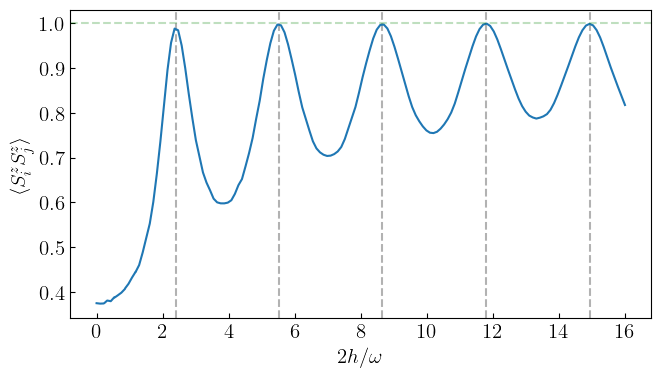

CPU times: user 401 ms, sys: 129 ms, total: 530 ms
Wall time: 1min 38s


In [11]:
%%time

freezing_pts = jn_zeros(0, 5)
plt.rcParams.update({"figure.figsize": (7.5,4),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 15,"font.sans-serif": ["Helvetica"]})

N = 8
omega = 20
w = omega
T = 2 * np.pi/w
times = np.linspace(0, 300 * T, 1500, endpoint=False)
del_an = 1.5
beta = float('inf')
pos1 = 0
pos2 = 3

sx,sy,sz = sigmax(), sigmay(), sigmaz()
nprocs = 8
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)

hss = w/2 * np.linspace(0,16, 150)
hs = np.sort(np.append(hss, jn_zeros(0,5)))

fig, ax1 = plt.subplots(1,1)
#left, bottom, width, height = [0.55, 0.25, 0.3, 0.31]
#ax2 = fig.add_axes([left, bottom, width, height])


for i,xx in enumerate(jn_zeros(0,5)):
    ax1.axvline(x=xx, alpha=0.3, color = 'black', linestyle = '--')
    #ax2.axvline(x=xx, alpha=0.3, color = 'black', linestyle = '--')

i,j = pos1, pos2
id = qeye(2**i)
dim11 = j-i-1
id1 = qeye(2**dim11)
dim12 = N-1-j
id2 = qeye(2**dim12)
sz_cor = Qobj(tensor(id, tensor(sz, tensor(id1, tensor(sz,id2)))).full()) 

sz_o = qzero(2**N) + 1j * qzero(2**N)

param = [{'h0':0, 'h':h, 'omega':omega, 'N':N,\
           'opts':opts, 'sz_cor':sz_cor,\
           'beta':beta,'del_an':del_an,\
           'times':times} for h in hs]

data = p.map(run_dynm_corr_avg,param)

ax1.plot(2*hs/w, data)
ax1.set_ylabel(r"$\langle S^z_i S^z_j \rangle$")
ax1.tick_params(which='both', axis="x", direction="in")
ax1.tick_params(which='both', axis="y", direction="in")    
ax1.set_xlabel(r"$2h/\omega$")
ax1.axhline(y=1.0, color='green', alpha=0.25, linestyle='--')

'''
ax2.plot(2*hs/w, data)
ax2.set_ylabel(r"$\langle S^z_i S^z_j \rangle$", fontsize =10)
ax2.set_xlabel(r"$2h/\omega$", fontsize = 10, labelpad=0.0)
ax2.tick_params(which='both', axis="x", direction="in")
ax2.tick_params(which='both', axis="y", direction="in")
ax2.set_ylim(0.98,1.01)
ax2.axhline(y=1.0, color='green', alpha=0.25, linestyle='--')
'''

plt.savefig('corrN8sz0sz3avg_xxz_onlynn_an1p5.svg', dpi=300,bbox_inches='tight', pad_inches=0.0)
plt.savefig('corrN8sz0sz3avg_xxz_onlynn_an1p5.jpeg', dpi=300,bbox_inches='tight', pad_inches=0.0)


plt.show()

#### $\beta =0$

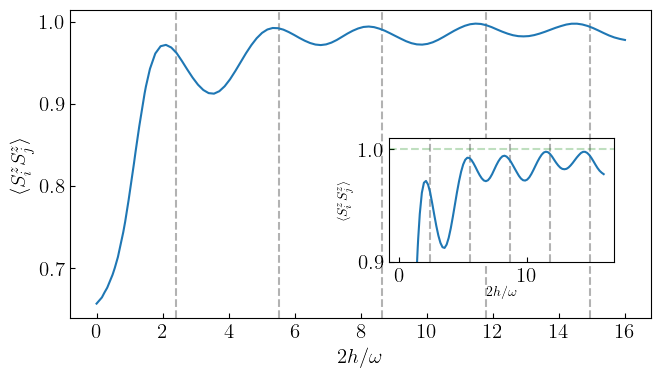

CPU times: user 343 ms, sys: 109 ms, total: 452 ms
Wall time: 1min 47s


In [22]:
%%time

freezing_pts = jn_zeros(0, 5)
plt.rcParams.update({"figure.figsize": (7.5,4),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 15,"font.sans-serif": ["Helvetica"]})

N = 8
omega = 20
w = omega
T = 2 * np.pi/w
times = np.linspace(0, 300 * T, 1500, endpoint=False)
del_an = 1.5
beta = 0.0
pos1 = 0
pos2 = 3

sx,sy,sz = sigmax(), sigmay(), sigmaz()
nprocs = 8
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)

hss = w/2 * np.linspace(0,16, 100)
hs = np.sort(np.append(hss, jn_zeros(0,5)))

fig, ax1 = plt.subplots(1,1)
left, bottom, width, height = [0.55, 0.25, 0.3, 0.31]
ax2 = fig.add_axes([left, bottom, width, height])


for i,xx in enumerate(jn_zeros(0,5)):
    ax1.axvline(x=xx, alpha=0.3, color = 'black', linestyle = '--')
    ax2.axvline(x=xx, alpha=0.3, color = 'black', linestyle = '--')

i,j = pos1, pos2
id = qeye(2**i)
dim11 = j-i-1
id1 = qeye(2**dim11)
dim12 = N-1-j
id2 = qeye(2**dim12)
sz_cor = Qobj(tensor(id, tensor(sz, tensor(id1, tensor(sz,id2)))).full()) 

sz_o = qzero(2**N) + 1j * qzero(2**N)

param = [{'h0':0, 'h':h, 'omega':omega, 'N':N,\
           'opts':opts, 'sz_cor':sz_cor,\
           'beta':beta,'del_an':del_an,\
           'times':times} for h in hs]

data = p.map(run_dynm_corr_avg,param)

ax1.plot(2*hs/w, data)
ax1.set_ylabel(r"$\langle S^z_i S^z_j \rangle$")
ax1.tick_params(which='both', axis="x", direction="in")
ax1.tick_params(which='both', axis="y", direction="in")    
ax1.set_xlabel(r"$2h/\omega$")

ax2.plot(2*hs/w, data)
ax2.set_ylabel(r"$\langle S^z_i S^z_j \rangle$", fontsize =10)
ax2.set_xlabel(r"$2h/\omega$", fontsize = 10, labelpad=0.0)
ax2.tick_params(which='both', axis="x", direction="in")
ax2.tick_params(which='both', axis="y", direction="in")
ax2.set_ylim(0.9,1.01)
ax2.axhline(y=1.0, color='green', alpha=0.25, linestyle='--')

plt.savefig('corrN8sz0sz3avg_xxz_a2a_an1p5.svg', dpi=300,bbox_inches='tight', pad_inches=0.0)

plt.show()

## $H(t)=\sum_i\hat{\sigma}^z_i \hat{\sigma}^z_{i+1} + h(t) \sum_i\hat{\sigma}^z_i$

In [24]:
from qutip import *
from scipy import signal
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.special import jn_zeros
from itertools import combinations
from multiprocessing import Pool
from tqdm import tqdm

##--- Energy per spin for interaction range order---------
def j_ij(Jvalue, i,j, beta):
    return Jvalue/(np.abs(i-j))**beta

##-- Drive-------------------------------------------------
from scipy.sparse import dia_matrix

def get_jmat_pbc(lsize, beta):
    N = lsize
    J = dia_matrix((N, N))
    mid_diag = np.floor(N/2).astype(int)
    for i in np.arange(1,mid_diag+1):
        elem = pow(i, -beta)
        J.setdiag(elem, k=i)
        J.setdiag(elem, k=-i)
    for i in np.arange(mid_diag+1, N):
        elem = pow(N-i, -beta)
        J.setdiag(elem, k=i)
        J.setdiag(elem, k=-i)
    return J.toarray()

def drive(t, args):
    h = args['h']
    w = args['omega']
    return h * np.cos(w * t)

def get_hamiltonian(N, beta, del_an):
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)
    H11, H12, H13, H21 =  empt, empt, empt, empt    
    
    jmat = get_jmat_pbc(N, beta)
    ##-- Hamiltonian ---------------------------------------

    comb = combinations(np.arange(N), 2)
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H11 = H11 + Qobj(tensor(id, tensor(sz, tensor(id1,tensor(sz,id2)))).full()) * jmat[i,j]
        
    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H21 = H21 + Qobj(tensor(id,tensor(sz,id1)).full()) 
    
    return 0.5*H11, 0.5*H21

##-- Dynamics
def run_dynm_corr(args):
    N=args['N']
    beta , sz_cor, del_an = args['beta'], args['sz_cor'], args['del_an']
    H11, H12, H13, H21 =  get_hamiltonian(N, beta, del_an)
    
    params = args
    #H = [H21,[H22,drive]]
    H = [H11,H12,H13,[H21,drive]]
    grket = basis(2**N,0)        
    out = mesolve(H, grket, times, [], [sz_cor], args = params)
    return out.expect

def run_dynm_corr_avg(args):
    N=args['N']
    beta , sz_cor, del_an = args['beta'], args['sz_cor'], args['del_an']    
    H11, H12, H13, H21 =  get_hamiltonian(N, beta, del_an)
    
    params = args
    H = [H11,[H21,drive]]
    grket = basis(2**N,0)        
    out = mesolve(H, grket, times, [], [sz_cor], args = params)
    return np.average(out.expect)

print('Function defined ..')

Function defined ..


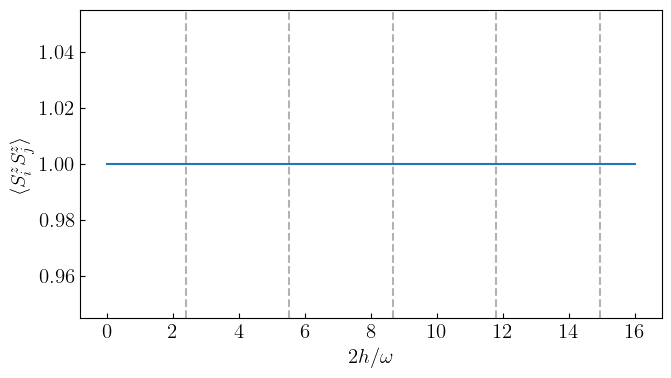

CPU times: user 129 ms, sys: 119 ms, total: 247 ms
Wall time: 48.4 s


In [27]:
%%time

freezing_pts = jn_zeros(0, 5)
plt.rcParams.update({"figure.figsize": (7.5,4),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 15,"font.sans-serif": ["Helvetica"]})

N = 8
omega = 90
w = omega
T = 2 * np.pi/w
times = np.linspace(0, 300 * T, 1500, endpoint=False)
del_an = 1.5
beta = 0.0
pos1 = 0
pos2 = 3

sx,sy,sz = sigmax(), sigmay(), sigmaz()
nprocs = 8
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)

hss = w/2 * np.linspace(0,16, 100)
hs = np.sort(np.append(hss, jn_zeros(0,5)))

fig, ax1 = plt.subplots(1,1)
left, bottom, width, height = [0.55, 0.25, 0.3, 0.31]
#ax2 = fig.add_axes([left, bottom, width, height])


for i,xx in enumerate(jn_zeros(0,5)):
    ax1.axvline(x=xx, alpha=0.3, color = 'black', linestyle = '--')
    ax2.axvline(x=xx, alpha=0.3, color = 'black', linestyle = '--')

i,j = pos1, pos2
id = qeye(2**i)
dim11 = j-i-1
id1 = qeye(2**dim11)
dim12 = N-1-j
id2 = qeye(2**dim12)
sz_cor = Qobj(tensor(id, tensor(sz, tensor(id1, tensor(sz,id2)))).full()) 

sz_o = qzero(2**N) + 1j * qzero(2**N)

param = [{'h0':0, 'h':h, 'omega':omega, 'N':N,\
           'opts':opts, 'sz_cor':sz_cor,\
           'beta':beta,'del_an':del_an,\
           'times':times} for h in hs]

data = p.map(run_dynm_corr_avg,param)

ax1.plot(2*hs/w, data)
ax1.set_ylabel(r"$\langle S^z_i S^z_j \rangle$")
ax1.tick_params(which='both', axis="x", direction="in")
ax1.tick_params(which='both', axis="y", direction="in")    
ax1.set_xlabel(r"$2h/\omega$")

#plt.savefig('corrN8sz0sz3avg_xxz_a2a_an1p5.svg', dpi=300,bbox_inches='tight', pad_inches=0.0)

plt.show()

# XXZ model

Hamiltonian,

\begin{equation}
\hat{H}(t) = \frac12\Bigg[J\sum_{ij} (\hat{\sigma}^x_i \hat{\sigma}^x_j +\hat{\sigma}^y_i \hat{\sigma}^y_j)+ \Delta\hat{\sigma}^z_i \hat{\sigma}^z_j+ h \cos(\omega t)\sum_i \hat{\sigma}^z_i + \sum_i \hat{\sigma}^x_i\Bigg]
\end{equation}

In [4]:
from qutip import *
from scipy import signal
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.special import jn_zeros
from itertools import combinations
from multiprocessing import Pool
from tqdm import tqdm

##--- Energy per spin for interaction range order---------
def j_ij(Jvalue, i,j, beta):
    return Jvalue/(np.abs(i-j))**beta

##-- Drive-------------------------------------------------
from scipy.sparse import dia_matrix

def get_jmat_pbc(lsize, beta):
    N = lsize
    J = dia_matrix((N, N))
    mid_diag = np.floor(N/2).astype(int)
    for i in np.arange(1,mid_diag+1):
        elem = pow(i, -beta)
        J.setdiag(elem, k=i)
        J.setdiag(elem, k=-i)
    for i in np.arange(mid_diag+1, N):
        elem = pow(N-i, -beta)
        J.setdiag(elem, k=i)
        J.setdiag(elem, k=-i)
    return J.toarray()

def drive(t, args):
    h = args['h']
    w = args['omega']
    return h * np.cos(w * t)

def get_hamiltonian(N, beta, del_an):
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)
    H11, H12, H13, H21, H22 =  empt, empt, empt, empt, empt
    
    
    jmat = get_jmat_pbc(N, beta)
    ##-- Hamiltonian ---------------------------------------

    comb = combinations(np.arange(N), 2)
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H11 = H11 + Qobj(tensor(id, tensor(sx, tensor(id1,tensor(sx,id2)))).full()) * jmat[i,j]
        
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H12 = H12 + Qobj(tensor(id, tensor(sy, tensor(id1,tensor(sy,id2)))).full()) * jmat[i,j]
        
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H13 = H13 + Qobj(tensor(id, tensor(sz, tensor(id1,tensor(sz,id2)))).full()) * jmat[i,j] * del_an
        
    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H21 = H21 + Qobj(tensor(id,tensor(sz,id1)).full()) 
        
    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H22 = H22 + Qobj(tensor(id,tensor(sx,id1)).full())
    
    return 0.5*H11, 0.5*H12, 0.5*H13, 0.5*H21, 0.5*H22

##-- Dynamics
def run_dynm_corr(args):
    N=args['N']
    beta , sz_cor, del_an = args['beta'], args['sz_cor'], args['del_an']
    H11, H12, H13, H21, H22 =  get_hamiltonian(N, beta, del_an)
    
    params = args
    #H = [H21,[H22,drive]]
    H = [H11,H12,H13,[H21,drive], H22]
    grket = basis(2**N,0)        
    out = mesolve(H, grket, times, [], [sz_cor], args = params)
    return out.expect

def run_dynm_corr_avg(args):
    N=args['N']
    beta , sz_cor, del_an = args['beta'], args['sz_cor'], args['del_an']    
    H11, H12, H13, H21, H22 =  get_hamiltonian(N, beta, del_an)
    
    params = args
    H = [H11,H12,H13,[H21,drive], H22]
    grket = basis(2**N,0)        
    out = mesolve(H, grket, times, [], [sz_cor], args = params)
    return np.average(out.expect)

print('Function defined ..')

Function defined ..


beta= inf


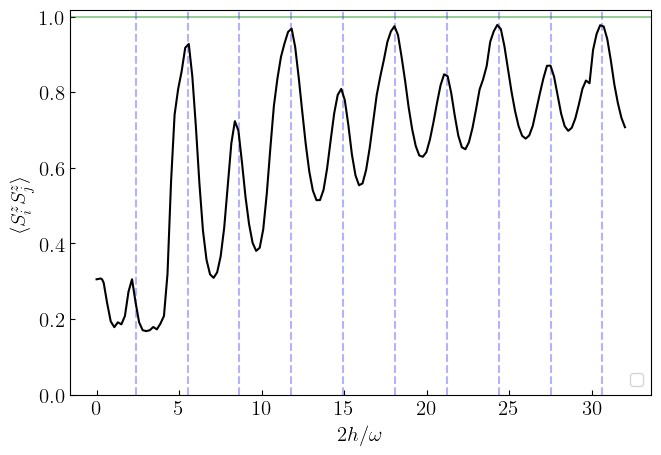

CPU times: user 386 ms, sys: 170 ms, total: 556 ms
Wall time: 3min 59s


In [5]:
%%time

freezing_pts = jn_zeros(0, 5)
plt.rcParams.update({"figure.figsize": (7.5,5),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 15,"font.sans-serif": ["Helvetica"]})

N = 8
omega = 90
w = omega
T = 2 * np.pi/w
times = np.linspace(0, 300 * T, 1500, endpoint=False)
del_an = 0.5
# Strong spin-coupling
#Jvalue = 1

# Weak spin-coupling
#Jvalue = 0.027/T

betas = [0.5, 1.5, 2.5, float('inf')]
betas = [float('inf')]
pos1 = 0
pos2 = 3

sx,sy,sz = sigmax(), sigmay(), sigmaz()
nprocs = 8
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)

hss = w/2 * np.linspace(0,32, 150)
hs = np.sort(np.append(hss, jn_zeros(0,5)))
for i,xx in enumerate(jn_zeros(0,10)):
    plt.axvline(x=xx, alpha=0.3, color = 'blue', linestyle = '--')

i,j = pos1, pos2
id = qeye(2**i)
dim11 = j-i-1
id1 = qeye(2**dim11)
dim12 = N-1-j
id2 = qeye(2**dim12)
sz_cor = Qobj(tensor(id, tensor(sz, tensor(id1, tensor(sz,id2)))).full()) 

for b, beta in enumerate(betas):
    sz_o = qzero(2**N) + 1j * qzero(2**N)
    print('beta=',beta)

    param = [{'h0':0, 'h':h, 'omega':omega, 'N':N,\
               'opts':opts, 'sz_cor':sz_cor,\
               'beta':beta,'del_an':del_an,\
               'times':times} for h in hs]

    data = p.map(run_dynm_corr_avg,param)

    #plt.plot(2*hs/w, data, label=fr'$\beta={beta}$')
    plt.plot(2*hs/w, data, color='black')
    #plt.legend(frameon =True, fontsize =12)
    plt.ylabel(r"$\langle S^z_i S^z_j \rangle$")
    plt.tick_params(which='both', axis="x", direction="in")
    plt.tick_params(which='both', axis="y", direction="in")
    

plt.xlabel(r"$2h/\omega$")
plt.yticks([0,.2,.4,.6,.8,1.])
plt.legend(frameon =True, fontsize =12, ncol=2, loc=4)
#plt.title(fr"$N={N}, i={i}, j={j}$", fontsize= 14)
plt.axhline(y=1.0, color= 'green', alpha = 0.4)
plt.savefig('corrN8sz0sz3avg_xxz_sxan0p5.svg', dpi=300,bbox_inches='tight', pad_inches=0.0)
plt.show()

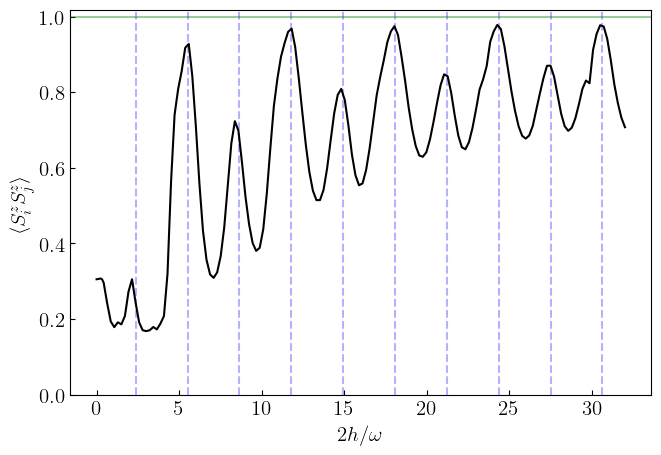

In [8]:
for i,xx in enumerate(jn_zeros(0,10)):
    plt.axvline(x=xx, alpha=0.3, color = 'blue', linestyle = '--')
plt.plot(2*hs/w, data, color='black')
#plt.legend(frameon =True, fontsize =12)
plt.ylabel(r"$\langle S^z_i S^z_j \rangle$")
plt.tick_params(which='both', axis="x", direction="in")
plt.tick_params(which='both', axis="y", direction="in")
    

plt.xlabel(r"$2h/\omega$")
plt.yticks([0,.2,.4,.6,.8,1.])
#plt.legend(frameon =True, fontsize =12, ncol=2, loc=4)
#plt.title(fr"$N={N}, i={i}, j={j}$", fontsize= 14)
plt.axhline(y=1.0, color= 'green', alpha = 0.4)
plt.savefig('corrN8sz0sz3avg_xxz_sxan0p5.jpeg', dpi=300,bbox_inches='tight', pad_inches=0.0)
plt.show()